<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Klasyfikacja_z_wykorzystaniem_drzew_decyzyjnych_RG/Klasyfikacja_drzewa_decyzyjne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikacja z wykorzystaniem drzew decyzyjnych

## Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [4]:
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType

Utowrzenie sesji:

In [5]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Połączenie z dyskiem:

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [7]:
columns = ['lon', 'lat', 'Date', 'Rainf', 'Evap', 'AvgSurfT', 'Albedo','SoilT_10_40cm', 'GVEG', 'PotEvap', 'RootMoist', 'SoilM_100_200cm']

# Utworzenie schematu określającego typ zmiennych
schema = StructType()
for i in columns:
  if i == "Date":
    schema = schema.add(i, IntegerType(), True)
  else:
    schema = schema.add(i, FloatType(), True)

In [8]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schema).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')
nasa.show(5)

+---------+-------+------+-----+---------+---------+---------+-------------+----------+---------+----------+---------------+
|      lon|    lat|  Date|Rainf|     Evap| AvgSurfT|   Albedo|SoilT_10_40cm|      GVEG|  PotEvap| RootMoist|SoilM_100_200cm|
+---------+-------+------+-----+---------+---------+---------+-------------+----------+---------+----------+---------------+
|-112.0625|25.0625|200001|  0.0|   4.3807| 288.0707| 41.47715|    289.00714|0.19712792|139.13737|  243.2525|      108.76931|
|-111.9375|25.0625|200001|  0.0|4.6673994|287.39276|41.509407|     288.8017|0.19860405|162.25638| 220.77466|       90.67495|
|-111.8125|25.0625|200001|  0.0|5.8487973| 287.6554|41.505375|    289.55984|0.17118543|121.55404| 103.95005|      161.94794|
|-111.6875|25.0625|200001|  0.0|6.4366016| 287.5386|41.501343|    289.61142|0.17118543|127.63407|106.032845|      163.44402|
|-111.5625|25.0625|200001|  0.0|3.4506986| 287.2394|41.509407|     289.2371| 0.1429876|179.37668| 161.43001|      187.07886|


In [9]:
nasa.createOrReplaceTempView("nasa")


Rodzielenie kolumny "Date" na kolumny "Year" oraz "Month"


In [10]:
nasa_ym = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)
nasa_ym = nasa_ym.drop("Date")


In [11]:
nasa_ym.createOrReplaceTempView("nasa_ym")

## Budowa modeli

**Cel**:

Celem jest zbudowanie modeli do klasyfikacji czy wskazany punkt lokalizacyjny ze zbioru danych NASA jest: pustynia, stepem lub innym obszarem. Zbudowane zostana trzy modele:

* Model 1 - detekcja pustynia - step - inne
* Model 2 - detekcja pustynia - niepustynia
* Model 3 - detekcja step - niestep


**Proba danych**:

Dane wykorzystane do modelowania zostały stworzone po przez połączenie dwoch zbiorów danych:

* 500 lokalizacji *lon* i *lat* z określoną flagą 0, 1 w kolumnach *pustynia* lub *step* (reczna adnotacja)
* danych NASA z *lipca 2023*

**Metoda**:

Do modelowania uzyto metody drzew decyzyjnych.


### Import bibliotek

In [12]:
from typing import List
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

### Przygotowanie danych

In [13]:
NASA_sample_an = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/NASA_an.csv',sep=';')

Dodanie kolumny *klasa* z nastepujacym oslownikowaniem:

* **1** - pustynia
* **2** - step
* **3** - inne

Liczebnosci poszczegolnych klas w probce.

In [14]:
{1:NASA_sample_an['pustynia'].sum(), 2:NASA_sample_an['step'].sum() , 3:NASA_sample_an['pustynia'].count()- NASA_sample_an['pustynia'].sum()- NASA_sample_an['step'].sum()}

{1: 69, 2: 87, 3: 344}

In [15]:
NASA_sample_an['klasa'] = np.where(
                        NASA_sample_an['pustynia'] == 1, 1, np.where(
                        NASA_sample_an['step'] == 1,2,3)
                        )

In [16]:
NASA_sample_an.rename(columns = {'lon':'lon_sample', 'lat':'lat_sample'}, inplace = True)

In [17]:
NASA_sample_an

,lon_sample,lat_sample,pustynia,step,klasa
0,-98.4375,49.0625,0,0,3
1,-84.4375,51.9375,0,0,3
2,-100.5625,47.0625,0,0,3
3,-104.6875,48.8125,0,0,3
4,-95.1875,36.5625,0,0,3
...,...,...,...,...,...
495,-115.0625,30.3125,1,0,1
496,-96.1875,42.6875,0,0,3
497,-105.5625,28.0625,1,0,1
498,-71.8125,46.5625,0,0,3


In [18]:
spark_NASA_sample_an=spark.createDataFrame(NASA_sample_an)

In [19]:
spark_NASA_07_23 = spark.sql("""
                        SELECT
                        lon, lat, Rainf, Evap, AvgSurfT, Albedo, SoilT_10_40cm, GVEG, PotEvap, RootMoist, SoilM_100_200cm
                        FROM nasa_ym
                        WHERE Year = 2023 and Month = 7
                        """)

In [20]:
spark_NASA_sample_all = spark_NASA_07_23.join(
    spark_NASA_sample_an,
     [spark_NASA_07_23.lon==spark_NASA_sample_an.lon_sample , spark_NASA_07_23.lat==spark_NASA_sample_an.lat_sample],
    "inner"
    )

In [21]:
spark_NASA_sample_all=spark_NASA_sample_all.drop('lon_sample','lat_sample')

In [22]:
spark_NASA_sample_all.show(2)

+--------+-------+--------+-------+--------+--------+-------------+---------+--------+---------+---------------+--------+----+-----+
|     lon|    lat|   Rainf|   Evap|AvgSurfT|  Albedo|SoilT_10_40cm|     GVEG| PotEvap|RootMoist|SoilM_100_200cm|pustynia|step|klasa|
+--------+-------+--------+-------+--------+--------+-------------+---------+--------+---------+---------------+--------+----+-----+
|-75.4375|50.4375|163.4812|96.2371|291.4626|19.37634|     286.2038|0.5985841|237.9618| 476.5157|       232.0023|       0|   0|    3|
|-81.3125|31.3125|137.1483|128.616|301.9196|23.79167|     296.2021|0.6689634|256.8731|  444.809|       166.0028|       0|   0|    3|
+--------+-------+--------+-------+--------+--------+-------------+---------+--------+---------+---------------+--------+----+-----+
only showing top 2 rows



In [23]:
print((spark_NASA_sample_all.count(), len(spark_NASA_sample_all.columns)))

(500, 14)


In [24]:
pd_NASA_sample_all = spark_NASA_sample_all.toPandas()

In [25]:
pd_NASA_sample_all.head(5)

,lon,lat,Rainf,Evap,AvgSurfT,Albedo,SoilT_10_40cm,GVEG,PotEvap,RootMoist,SoilM_100_200cm,pustynia,step,klasa
0,-75.4375,50.4375,163.481201,96.237099,291.462585,19.376341,286.203796,0.598584,237.961807,476.515686,232.002304,0,0,3
1,-81.3125,31.3125,137.148300,128.615997,301.919586,23.791670,296.202087,0.668963,256.873108,444.808990,166.002808,0,0,3
2,-100.5625,46.3125,19.026400,93.919998,296.914307,26.689520,289.871399,0.478112,281.043701,210.011597,243.097305,0,1,2
3,-116.5625,38.0625,7.359899,8.502694,297.265106,33.471779,290.396606,0.102609,367.771393,149.184906,146.331894,1,0,1
4,-81.9375,27.4375,113.676201,105.082802,303.505188,24.659950,301.578308,0.589661,302.751007,248.133896,108.467400,0,0,3


Sprawdzenie, czy w danych występują braki - nie.

In [26]:
pd_NASA_sample_all.isnull().sum()

lon                0
lat                0
Rainf              0
Evap               0
AvgSurfT           0
Albedo             0
SoilT_10_40cm      0
GVEG               0
PotEvap            0
RootMoist          0
SoilM_100_200cm    0
pustynia           0
step               0
klasa              0
dtype: int64

#### Wydzielenie zbiorow danych

Zmienne kandydatki:

* **GVEG** - wskaznik roslinnosci
* **Rainf** - wskaznik opadow deszczu
* **Evap** - wskaznik calkowitej ewapotranspiracji
* **AvgSurfT** - wskaznik sredniej temperatury powierzchni ziemi
* **Albedo** - wskaznik albedo
* **SoilT_40_100cm** - wskaznik temperatury gleby w warstwie o glebokosci od 40 do 100 cm
* **PotEvap** - wskaznik potencjalnej ewapotranspiracji
* **RootMoist** - wilgotnosć gleby w strefie korzeniowej (parowanie, ktore mialoby miejsce, gdyby dostepne bylo wystarczajace zrodlo wody)
* **SoilM_100_200cm** - wilgotnosc gleby w warstwie o glebokosci od 100 do 200 cm




In [27]:
X = pd_NASA_sample_all.loc[:,'Rainf':'SoilM_100_200cm']
y_m1 = pd_NASA_sample_all['klasa']
y_m2 = pd_NASA_sample_all['pustynia']
y_m3 = pd_NASA_sample_all['step']

#### Definiowanie funkcji

In [28]:
def information_gain(X: pd.DataFrame, y: pd.DataFrame) -> None:
  importances = mutual_info_classif(X, y)
  feature_info = pd.Series(importances, X.columns).sort_values(ascending=False)
  print(feature_info)

In [29]:
def correlations(X: pd.DataFrame) -> None:
  cor = X.corr()
  sns.heatmap(cor, annot=True,cmap='Reds')

In [30]:
def plot_data_dist(y: pd.DataFrame) -> None:
  dane = pd.Series(y).value_counts().sort_index()
  labels = list(np.sort(pd.unique(y)))
  ypos=np.arange(len(labels))
  plt.xticks(ypos, labels)
  plt.xlabel('Klasa')
  plt.ylabel('Czestosc')
  plt.title('Liczebnosc dla proby')
  plt.bar(ypos,dane)

In [31]:
def summary_model(model, X:pd.DataFrame, y:pd.DataFrame, labels_names: List) -> None:
  y_pred = model.predict(X)
  y_real= y
  cf_matrix = confusion_matrix(y_real, y_pred)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(len(labels_names),len(labels_names))
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds',xticklabels=labels_names,yticklabels=labels_names)
  plt.xlabel('Predykcja')
  plt.ylabel('Rzeczywistość')
  plt.show()

In [32]:
def print_classification_report(model, X: pd.DataFrame, y: pd.DataFrame) -> None:
  y_predict = model.predict(X)
  print(classification_report(y, y_predict))

In [33]:
from typing import Optional, Tuple
from pandas import DataFrame
from imblearn.over_sampling import RandomOverSampler, SMOTE

class BalanceDataSet():
  '''
  Two techniques for handling imbalanced data.
  '''
  def __init__(
      self,
      X: DataFrame,
      y: DataFrame
      ) -> None:
      self.X = X
      self.y = y
      assert len(self.X)==len(self.y)

  def useOverSampling(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    oversample = RandomOverSampler( sampling_strategy='auto',
                  random_state=randon_seed)
    return oversample.fit_resample(self.X, self.y)

  def useSMOTE(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    smote = SMOTE(random_state=randon_seed)
    return smote.fit_resample(self.X, self.y)

### Model 1 - detekcja pustynia - step - inne

#### Podzial na zbior treningowy i testowy

In [38]:
X_m1_train, X_m1_test, y_m1_train, y_m1_test = train_test_split(X, y_m1, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m1_train, y_m1_train)

GVEG               0.518617
Albedo             0.348290
Evap               0.302285
Rainf              0.275095
RootMoist          0.177463
AvgSurfT           0.101603
SoilT_10_40cm      0.086708
PotEvap            0.083220
SoilM_100_200cm    0.076276
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

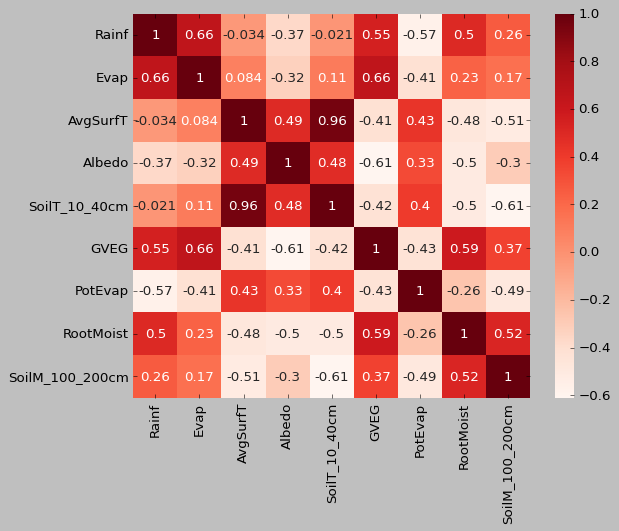

In [ ]:
correlations(X_m1_train)

Usuniecie zmiennych *SoilM_100_200cm* i *PotEvap*. Cechuja sie one mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 81% dla zbioru testowego.)

In [39]:
X_m1_train = X_m1_train.drop('SoilM_100_200cm',axis=1)
X_m1_test = X_m1_test.drop('SoilM_100_200cm',axis=1)
X_m1_train = X_m1_train.drop('PotEvap',axis=1)
X_m1_test = X_m1_test.drop('PotEvap',axis=1)

#### Zbalansowanie datasetu

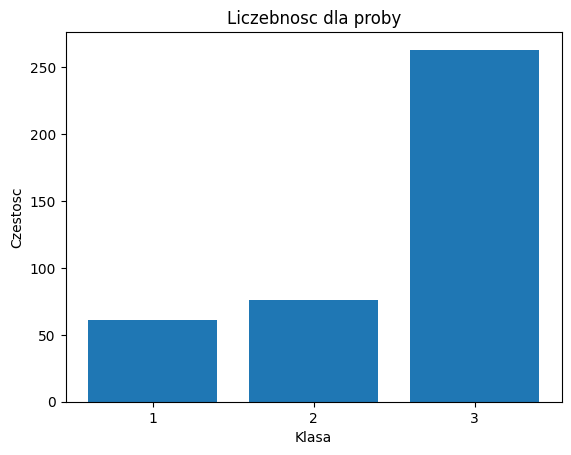

In [40]:
plot_data_dist(y_m1_train)

In [41]:
X_m1_train_bal, y_m1_train_bal = BalanceDataSet(X_m1_train, y_m1_train).useSMOTE()

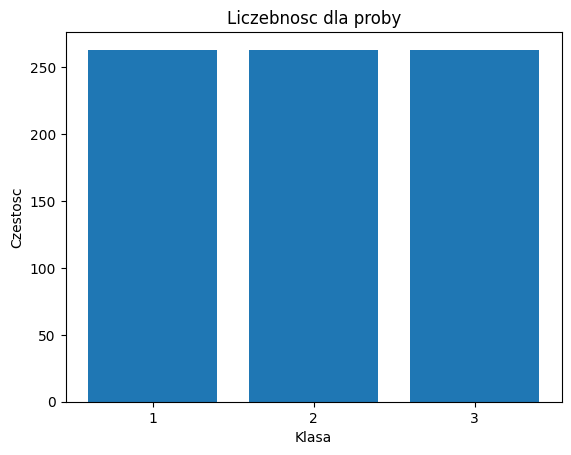

In [42]:
plot_data_dist(y_m1_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m1 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m1.fit(X_m1_train_bal, y_m1_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m1.score(X_m1_test,  y_m1_test) * 100))

classifier accuracy 85.00%


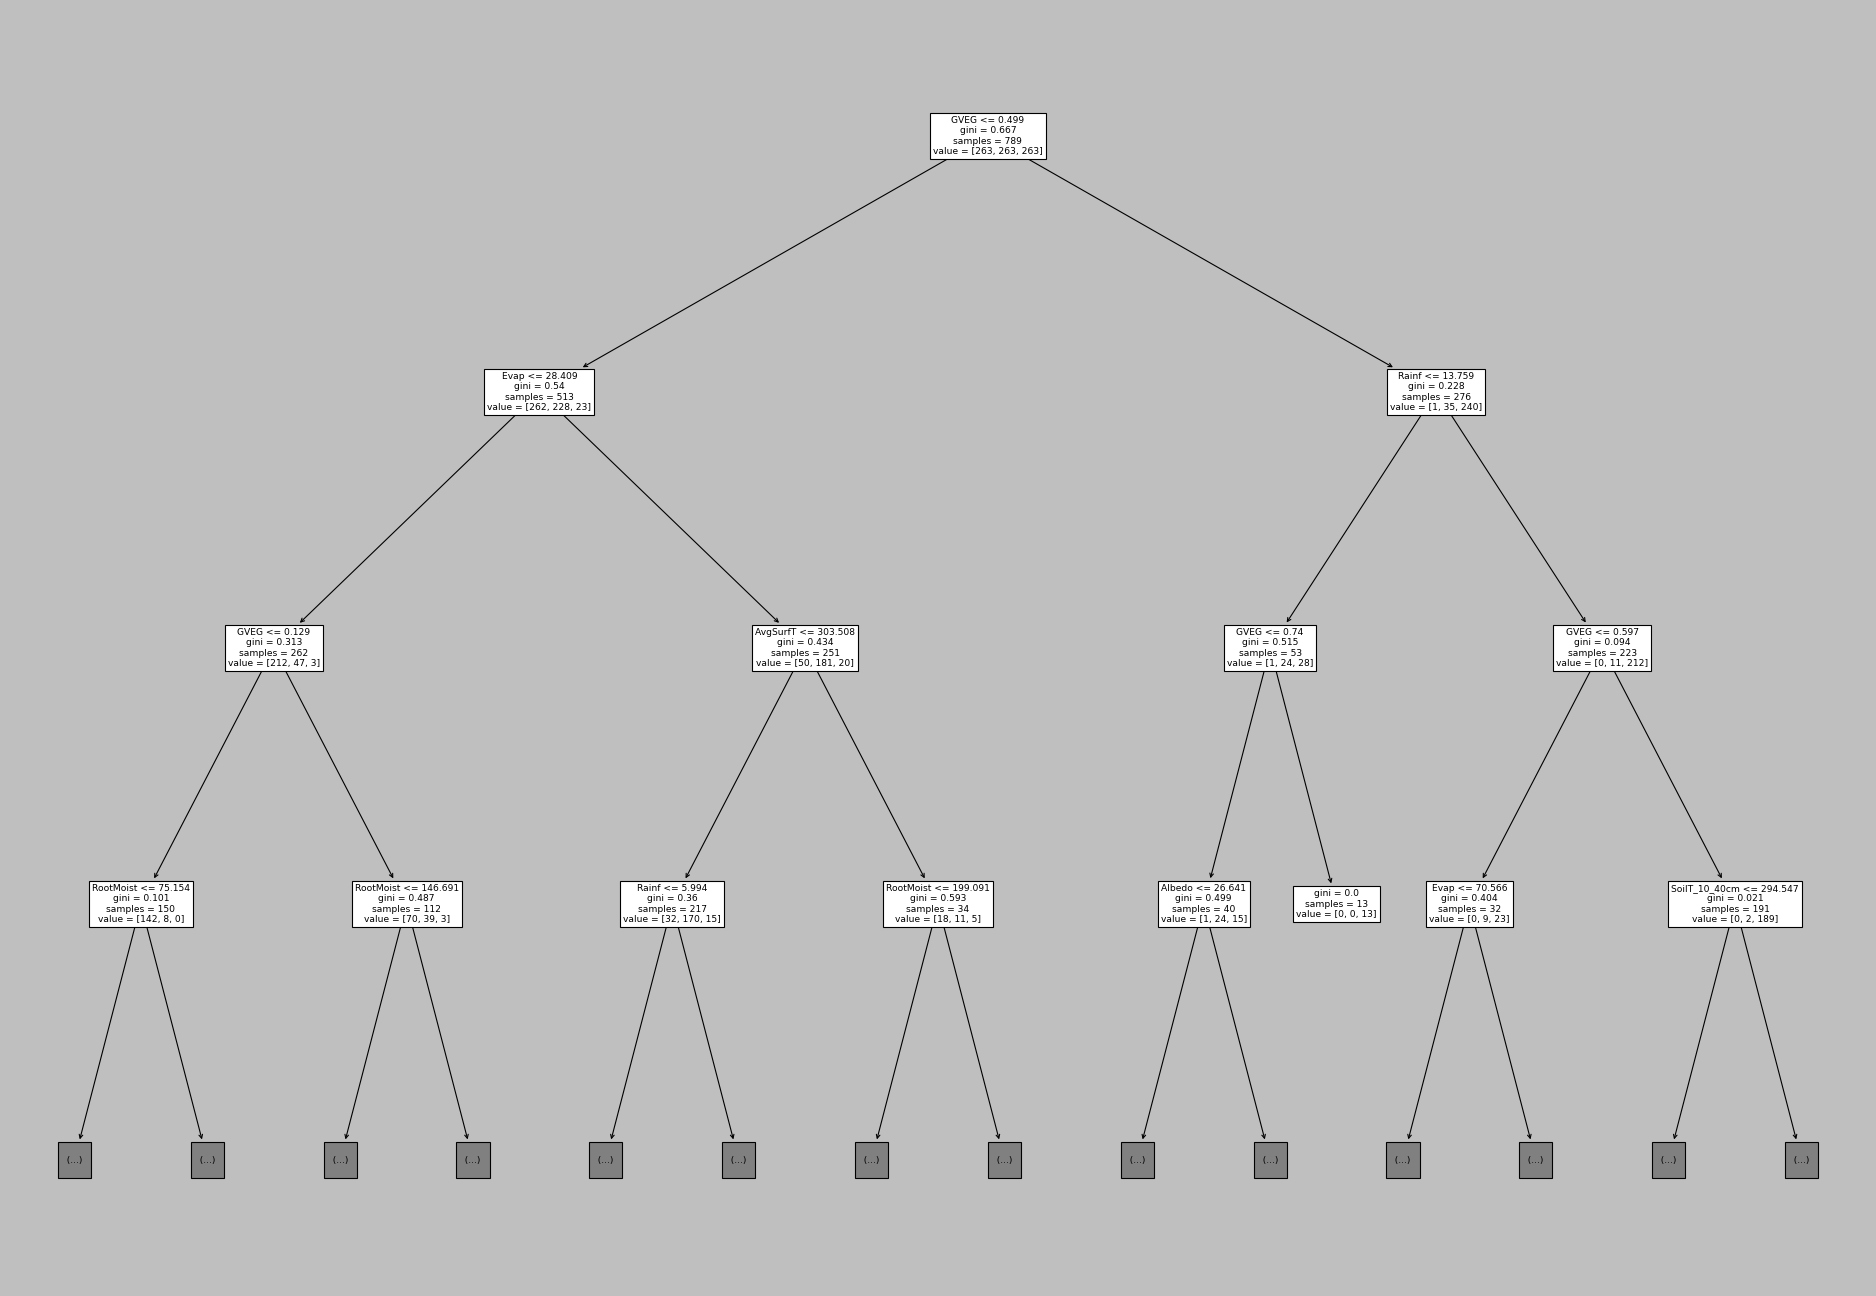

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m1, max_depth=3, feature_names=X_m1_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

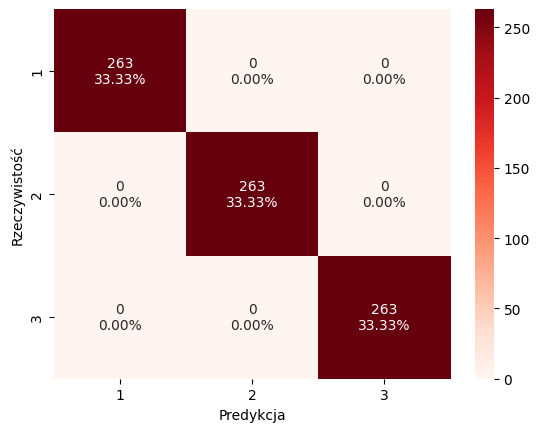

In [45]:
summary_model(tree_classifier_m1, X_m1_train_bal, y_m1_train_bal, ['1','2','3'])

In [46]:
print_classification_report(tree_classifier_m1, X_m1_train_bal, y_m1_train_bal)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       263
           2       1.00      1.00      1.00       263
           3       1.00      1.00      1.00       263

    accuracy                           1.00       789
   macro avg       1.00      1.00      1.00       789
weighted avg       1.00      1.00      1.00       789



Na danych testowych.

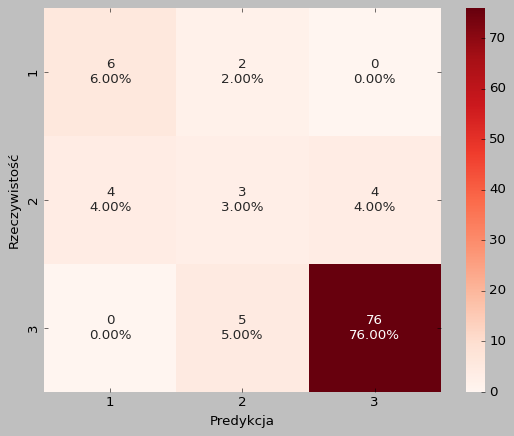

In [ ]:
summary_model(tree_classifier_m1, X_m1_test, y_m1_test, ['1','2','3'])

In [ ]:
print_classification_report(tree_classifier_m1, X_m1_test, y_m1_test)

              precision    recall  f1-score   support

           1       0.60      0.75      0.67         8
           2       0.30      0.27      0.29        11
           3       0.95      0.94      0.94        81

    accuracy                           0.85       100
   macro avg       0.62      0.65      0.63       100
weighted avg       0.85      0.85      0.85       100



#### Zapisanie modelu

In [ ]:
model_m1_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m1'

In [ ]:
#with open(model_m1_path, 'wb') as files:
#    pickle.dump(tree_classifier_m1, files)

### Model 2 - detekcja pustynia - niepustynia

#### Podzial na zbior treningowy i testowy

In [47]:
X_m2_train, X_m2_test, y_m2_train, y_m2_test = train_test_split(X, y_m2, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m2_train, y_m2_train)

GVEG               0.279603
Evap               0.208967
Albedo             0.170790
Rainf              0.123581
RootMoist          0.097584
AvgSurfT           0.083848
SoilT_10_40cm      0.065395
PotEvap            0.041968
SoilM_100_200cm    0.041307
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

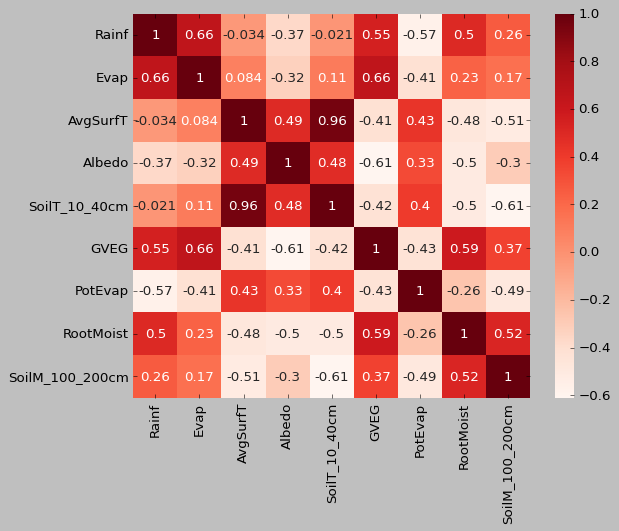

In [ ]:
correlations(X_m2_train)

Usuniecie zmiennych *SoilM_100_200cm* i *PotEvap*. Cechuja sie one mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 94% dla zbioru testowego.)

In [48]:
X_m2_train = X_m2_train.drop('SoilM_100_200cm',axis=1)
X_m2_test = X_m2_test.drop('SoilM_100_200cm',axis=1)
X_m2_train = X_m2_train.drop('PotEvap',axis=1)
X_m2_test = X_m2_test.drop('PotEvap',axis=1)

#### Zbalansowanie datasetu

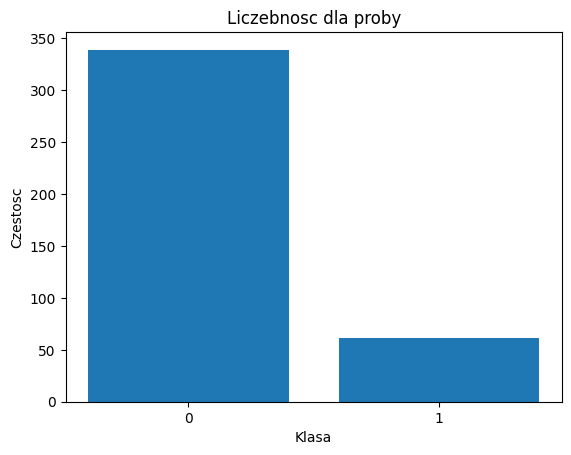

In [49]:
plot_data_dist(y_m2_train)

In [50]:
X_m2_train_bal, y_m2_train_bal = BalanceDataSet(X_m2_train, y_m2_train).useSMOTE()

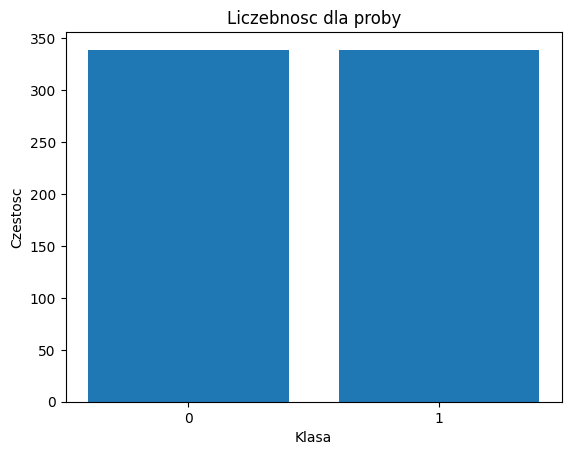

In [51]:
plot_data_dist(y_m2_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m2 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m2.fit(X_m2_train_bal, y_m2_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m2.score(X_m2_test,  y_m2_test) * 100))

classifier accuracy 96.00%


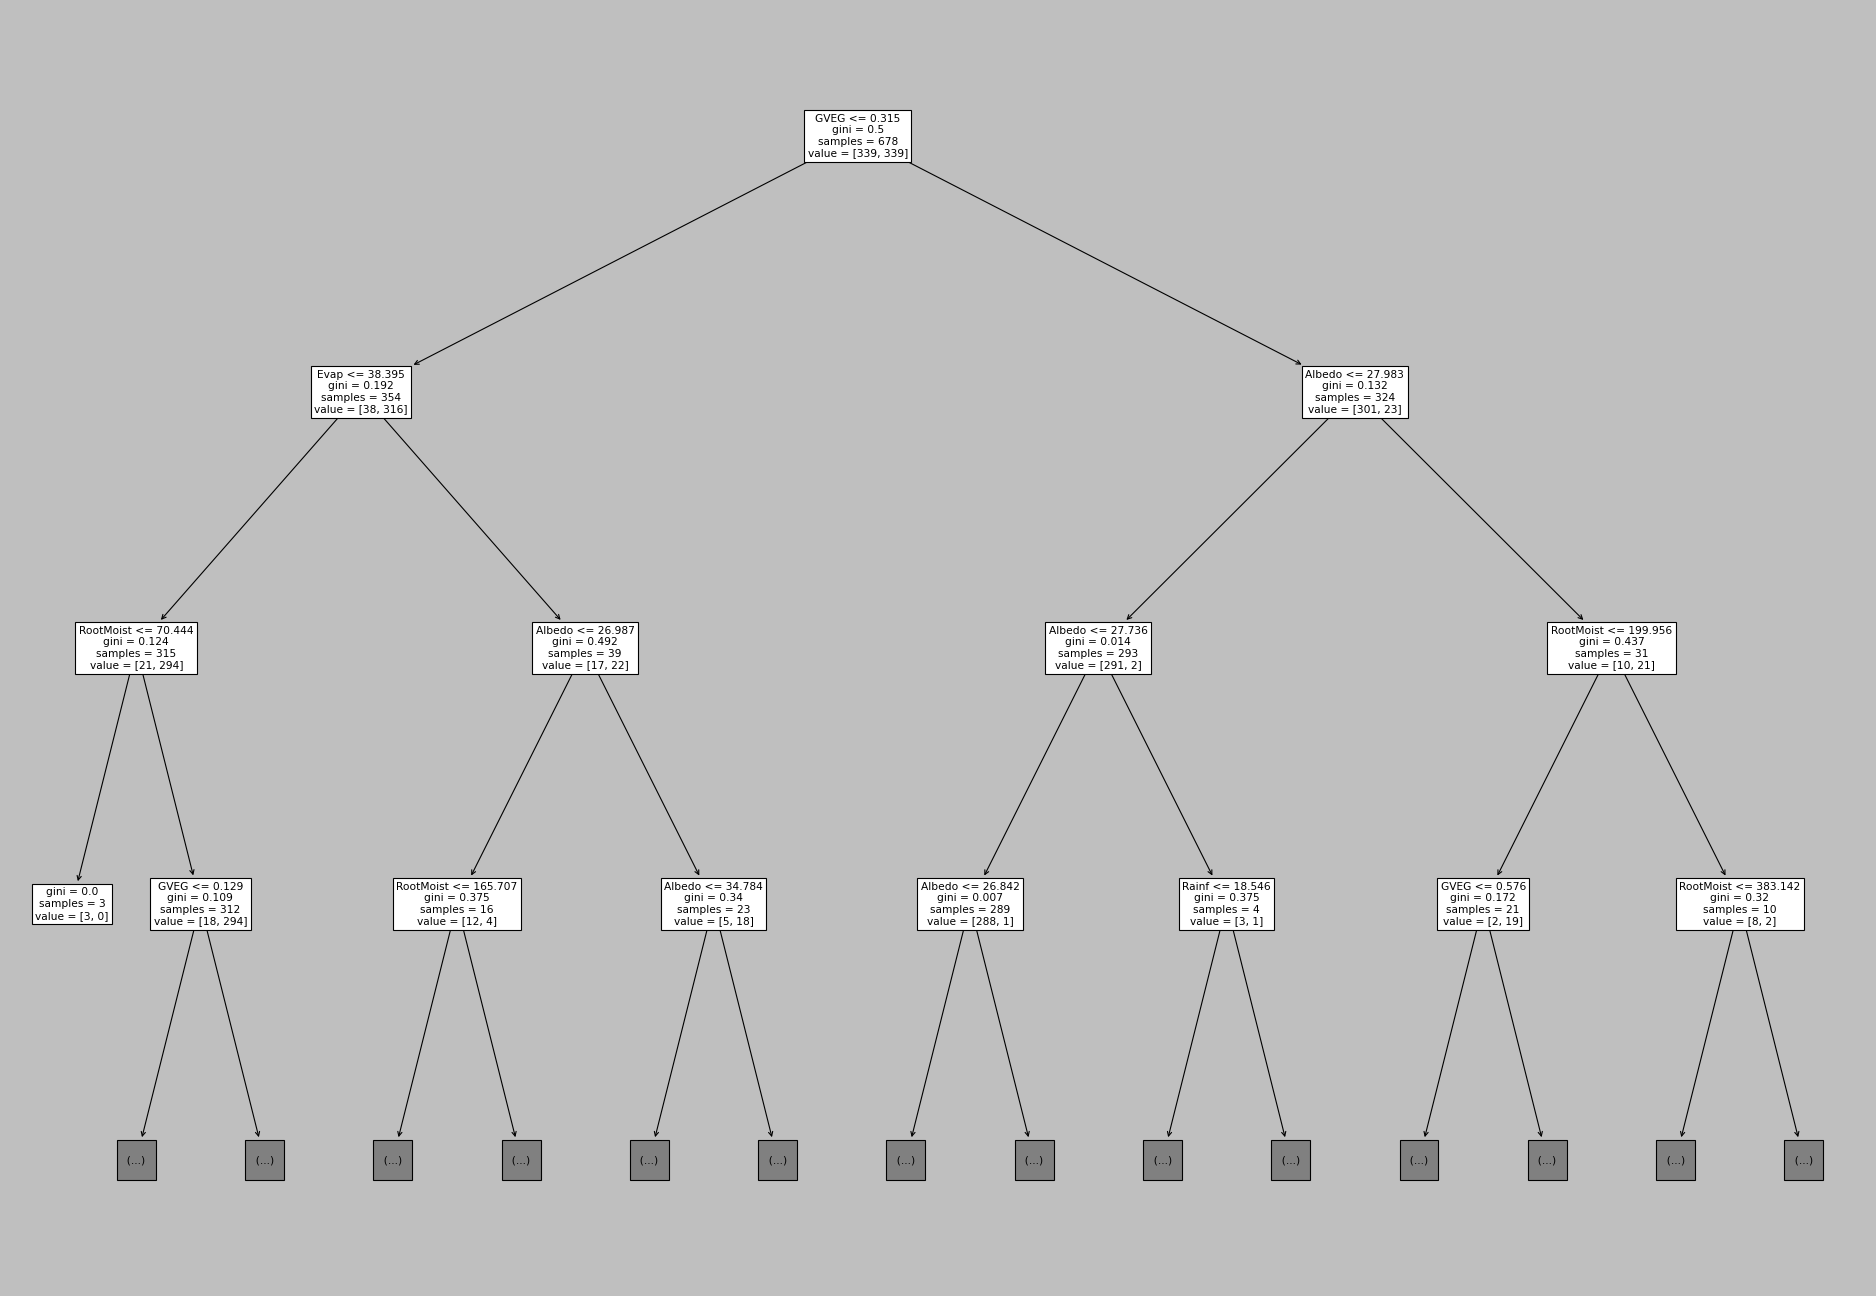

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m2, max_depth=3, feature_names=X_m2_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

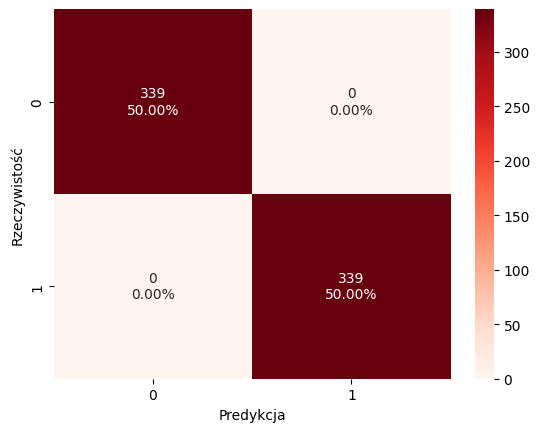

In [63]:
summary_model(tree_classifier_m2, X_m2_train_bal, y_m2_train_bal, ['0', '1'])

In [54]:
print_classification_report(tree_classifier_m2, X_m2_train_bal, y_m2_train_bal)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       339
           1       1.00      1.00      1.00       339

    accuracy                           1.00       678
   macro avg       1.00      1.00      1.00       678
weighted avg       1.00      1.00      1.00       678



Na danych testowych.

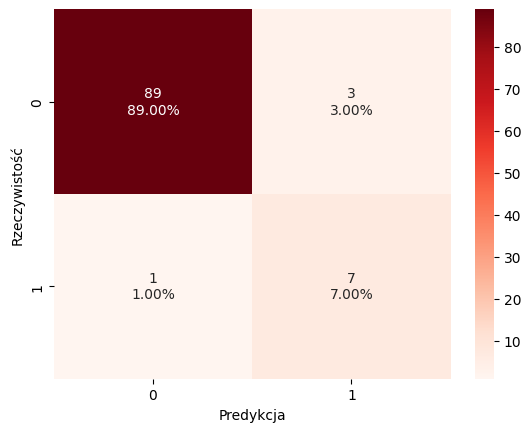

In [64]:
summary_model(tree_classifier_m2, X_m2_test, y_m2_test, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m2, X_m2_test, y_m2_test)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        92
           1       0.70      0.88      0.78         8

    accuracy                           0.96       100
   macro avg       0.84      0.92      0.88       100
weighted avg       0.97      0.96      0.96       100



#### Zapisanie modelu

In [ ]:
model_m2_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m2'

In [ ]:
#with open(model_m2_path, 'wb') as files:
#    pickle.dump(tree_classifier_m2, files)

### Model 3 - detekcja step - niestep

#### Podzial na zbior treningowy i testowy

In [55]:
X_m3_train, X_m3_test, y_m3_train, y_m3_test = train_test_split(X, y_m3, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m3_train, y_m3_train)

GVEG               0.167704
Rainf              0.125119
Albedo             0.098767
Evap               0.066965
RootMoist          0.063412
PotEvap            0.035190
SoilM_100_200cm    0.017214
AvgSurfT           0.010631
SoilT_10_40cm      0.010127
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

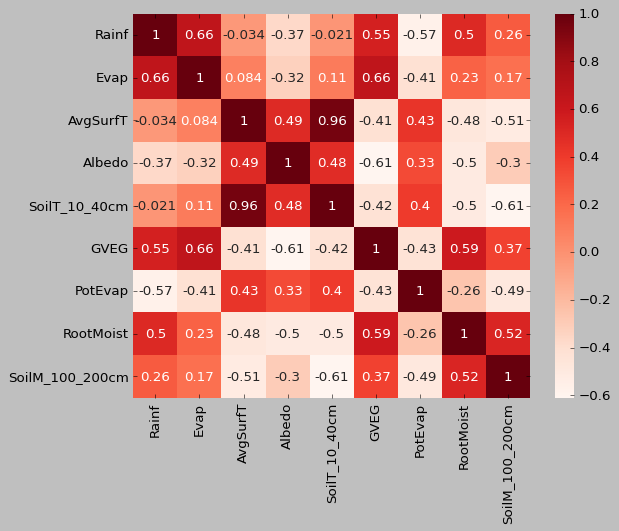

In [ ]:
correlations(X_m3_train)

Usuniecie zmiennych *SoilM_100_200cm*, *SoilT_10_40cm*, *AvgSurfT* i *PotEvap*. Cechuja sie one mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 82% dla zbioru testowego.)

In [56]:
X_m3_train = X_m3_train.drop('SoilM_100_200cm',axis=1)
X_m3_test = X_m3_test.drop('SoilM_100_200cm',axis=1)
X_m3_train = X_m3_train.drop('SoilT_10_40cm',axis=1)
X_m3_test = X_m3_test.drop('SoilT_10_40cm',axis=1)
X_m3_train = X_m3_train.drop('AvgSurfT',axis=1)
X_m3_test = X_m3_test.drop('AvgSurfT',axis=1)
X_m3_train = X_m3_train.drop('PotEvap',axis=1)
X_m3_test = X_m3_test.drop('PotEvap',axis=1)

#### Zbalansowanie datasetu

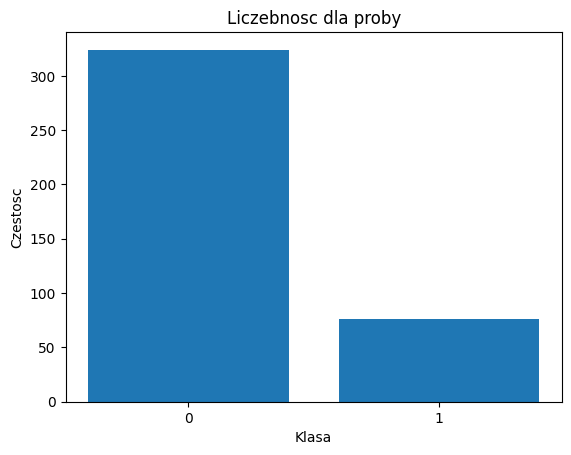

In [57]:
plot_data_dist(y_m3_train)

In [58]:
X_m3_train_bal, y_m3_train_bal = BalanceDataSet(X_m3_train, y_m3_train).useSMOTE()

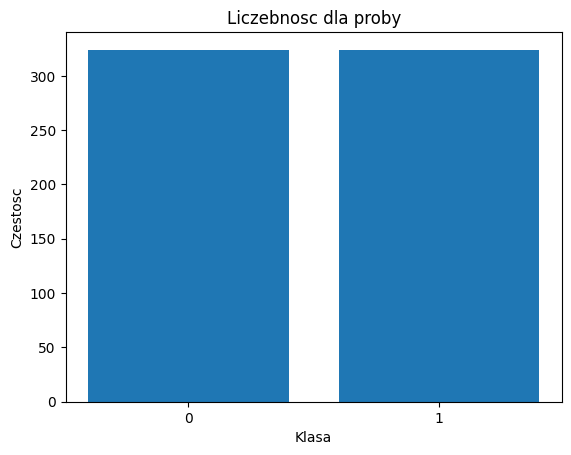

In [59]:
plot_data_dist(y_m3_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m3 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m3.fit(X_m3_train_bal, y_m3_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m3.score(X_m3_test,  y_m3_test) * 100))

classifier accuracy 88.00%


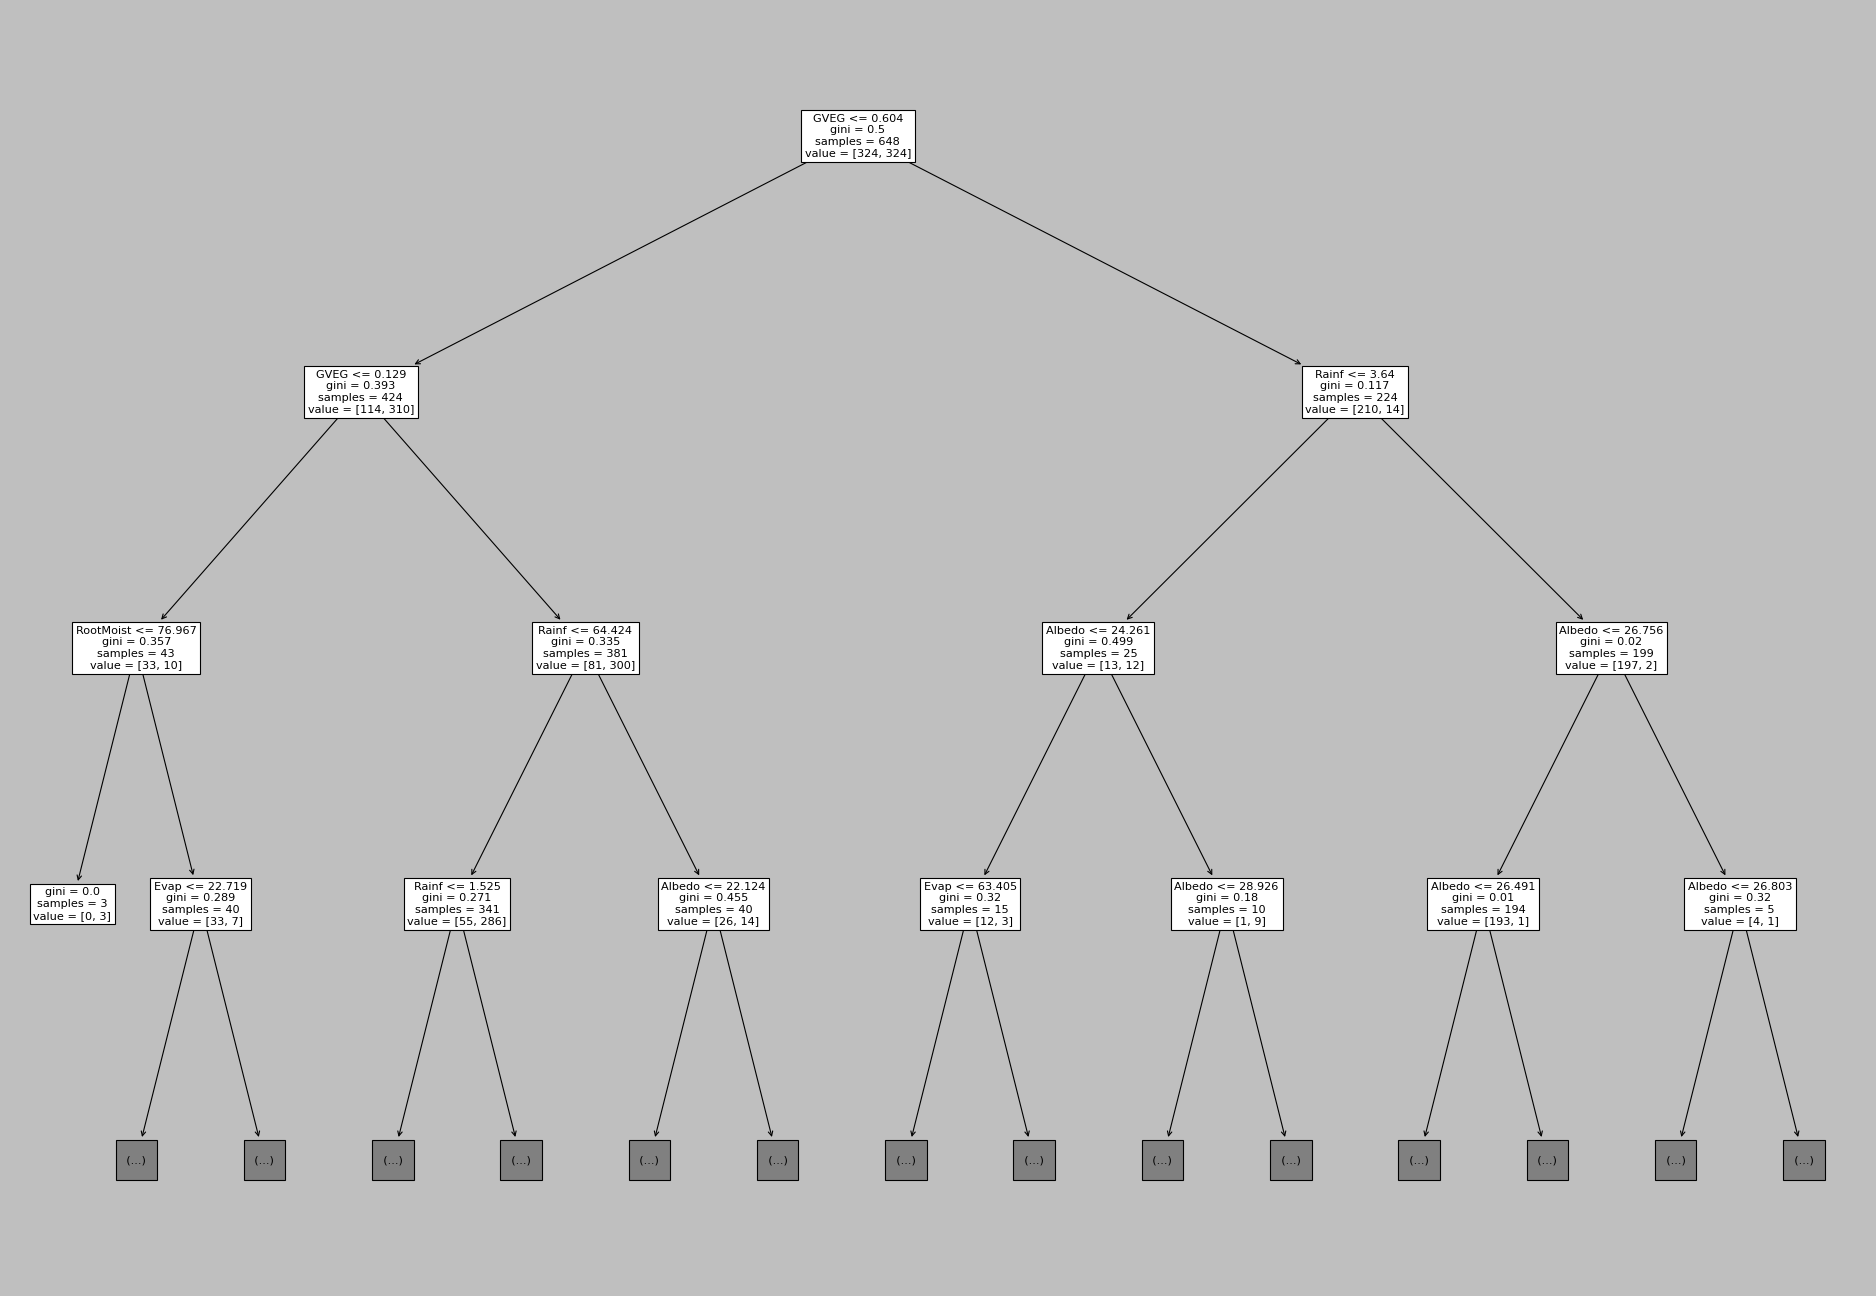

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m3, max_depth=3, feature_names=X_m3_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

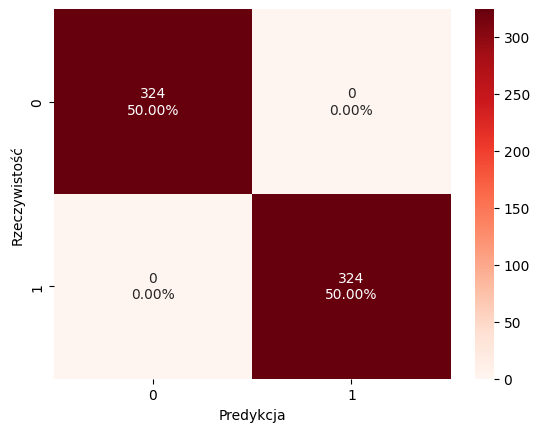

In [65]:
summary_model(tree_classifier_m3, X_m3_train_bal, y_m3_train_bal, ['0', '1'])

In [62]:
print_classification_report(tree_classifier_m3, X_m3_train_bal, y_m3_train_bal)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       1.00      1.00      1.00       324

    accuracy                           1.00       648
   macro avg       1.00      1.00      1.00       648
weighted avg       1.00      1.00      1.00       648



Na danych testowych.

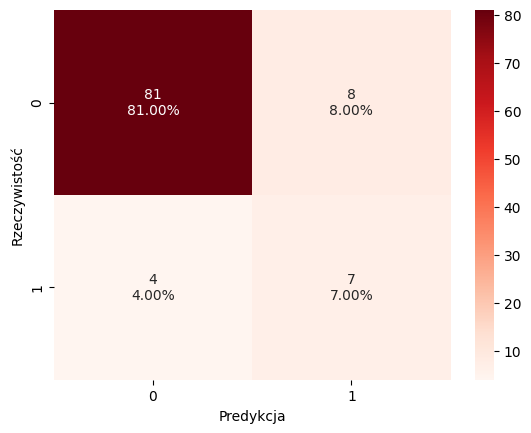

In [66]:
summary_model(tree_classifier_m3, X_m3_test, y_m3_test, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m3, X_m3_test, y_m3_test)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        89
           1       0.47      0.64      0.54        11

    accuracy                           0.88       100
   macro avg       0.71      0.77      0.73       100
weighted avg       0.90      0.88      0.89       100



#### Zapisanie modelu

In [ ]:
model_m3_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m3'

In [ ]:
#with open(model_m3_path, 'wb') as files:
#    pickle.dump(tree_classifier_m3, files)

### Podsumowanie

**Model 1 - detekcja pustynia - step - inne** \
Zmienne:

*	Rainf              
*	Evap               
*	AvgSurfT           
*	Albedo             
*	SoilT_10_40cm      
*	GVEG                           
*	RootMoist          


Zwraca *1*, *2* lub *3* gdzie:
* 1 - pustynia
* 2 - step
* 3 - inne


**Model 2 - detekcja pustynia - niepustynia** \
Zmienne:

*	Rainf              
*	Evap               
*	AvgSurfT           
*	Albedo             
*	SoilT_10_40cm      
*	GVEG                          
*	RootMoist          


Zwraca *0* lub *1* gdzie:
* 0 - niepustynia
* 1 - pustynia



**Model 3 - detekcja step - niestep** \
Zmienne:

*	Rainf              
*	Evap                         
*	Albedo                  
*	GVEG                          
*	RootMoist          


Zwraca *0* lub *1* gdzie:
* 0 - niestep
* 1 - step


Sciezki do modeli:

In [34]:
model_m1_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m1'
model_m2_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m2'
model_m3_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m3'

Przykladowy odczyt modelu.

In [ ]:
with open(model_m1_path , 'rb') as f:
    model = pickle.load(f)